In [ ]:
# Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.metrics import davies_bouldin_score
from datetime import datetime

# Load Dataset
data_path = "/content/Online Retail.xlsx"  # Update with your file path in Colab
df = pd.read_excel(data_path)

# Display first few rows
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Remove missing CustomerID
df = df.dropna(subset=['CustomerID'])

# Remove negative quantities and prices
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

# Focus only on UK customers
df = df[df['Country'] == 'United Kingdom']

# Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Compute Revenue per transaction
df['Revenue'] = df['Quantity'] * df['UnitPrice']

# Define snapshot date as the last available date + 1
snapshot_date = df['InvoiceDate'].max() + pd.DateOffset(1)

# Compute RFM Metrics
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',  # Frequency
    'Revenue': 'sum'  # Monetary Value
})

# Rename columns
rfm.columns = ['Recency', 'Frequency', 'Monetary']

# Remove negative or zero monetary values
rfm = rfm[rfm['Monetary'] > 0]

# Display summary statistics
rfm.describe()

<ipython-input-2-e53a9c3c7cd7>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
<ipython-input-2-e53a9c3c7cd7>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Revenue'] = df['Quantity'] * df['UnitPrice']


,Recency,Frequency,Monetary
count,3920.000000,3920.000000,3920.000000
mean,92.208418,4.246429,1864.385601
std,99.533854,7.199202,7482.817477
min,1.000000,1.000000,3.750000
25%,18.000000,1.000000,300.280000
50%,51.000000,2.000000,652.280000
75%,143.000000,5.000000,1576.585000
max,374.000000,209.000000,259657.300000


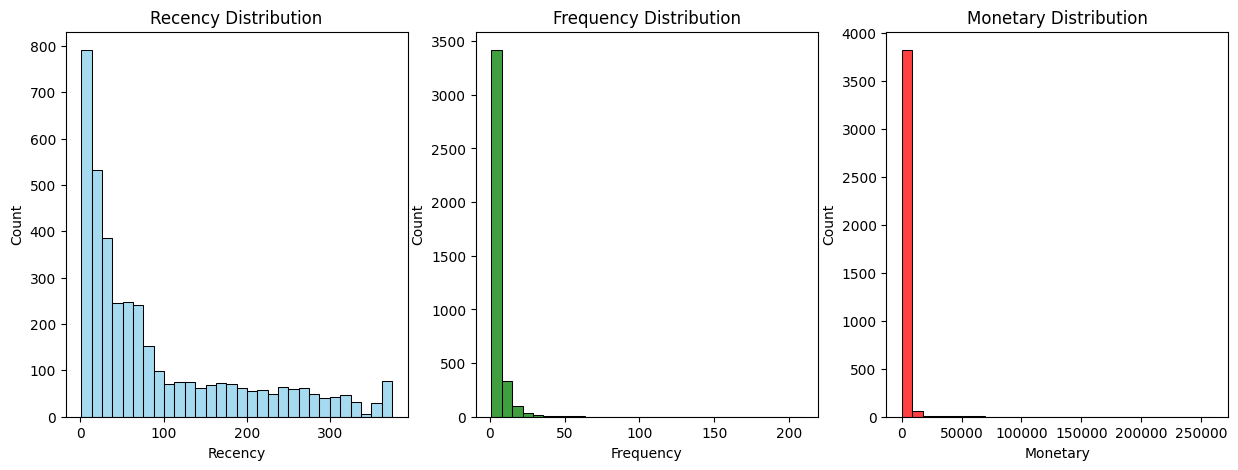

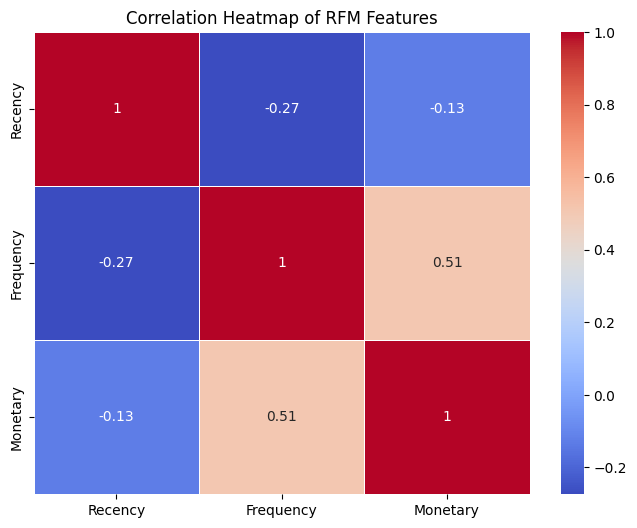

In [ ]:
# Plot RFM Distributions
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
sns.histplot(rfm['Recency'], bins=30, ax=axes[0], color='skyblue')
sns.histplot(rfm['Frequency'], bins=30, ax=axes[1], color='green')
sns.histplot(rfm['Monetary'], bins=30, ax=axes[2], color='red')

axes[0].set_title("Recency Distribution")
axes[1].set_title("Frequency Distribution")
axes[2].set_title("Monetary Distribution")
plt.show()

# Heatmap of RFM Correlations
plt.figure(figsize=(8,6))
sns.heatmap(rfm.corr(), annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap of RFM Features")
plt.show()

In [ ]:
# Standardizing the RFM values
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)

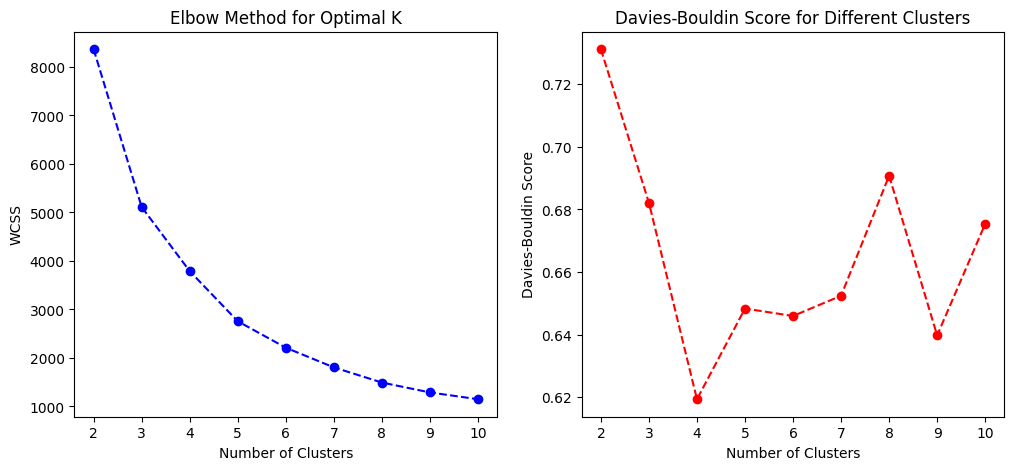

✅ Davies-Bouldin Score suggests the optimal number of clusters: 4


In [ ]:
# Finding optimal clusters using Davies-Bouldin Score and Elbow Method
davies_scores = []
wcss = []
cluster_range = range(2, 11)  # Checking from 2 to 10 clusters

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(rfm_scaled)
    wcss.append(kmeans.inertia_)  # Store WCSS for Elbow Method
    davies_scores.append(davies_bouldin_score(rfm_scaled, kmeans.labels_))  # Store Davies-Bouldin Score

# Plot Elbow Method (WCSS) & Davies-Bouldin Score
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(cluster_range, wcss, marker='o', linestyle='--', color='b')
plt.xlabel("Number of Clusters")
plt.ylabel("WCSS")
plt.title("Elbow Method for Optimal K")

plt.subplot(1, 2, 2)
plt.plot(cluster_range, davies_scores, marker='o', linestyle='--', color='r')
plt.xlabel("Number of Clusters")
plt.ylabel("Davies-Bouldin Score")
plt.title("Davies-Bouldin Score for Different Clusters")

plt.show()

# Select the best number of clusters
optimal_clusters = cluster_range[np.argmin(davies_scores)]
print(f"✅ Davies-Bouldin Score suggests the optimal number of clusters: {optimal_clusters}")

In [ ]:
# Apply K-Means with optimal clusters
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42, n_init=10)
rfm["Cluster_KMeans"] = kmeans.fit_predict(rfm_scaled)

# Calculate and display Davies-Bouldin Score
db_score_kmeans = davies_bouldin_score(rfm_scaled, rfm["Cluster_KMeans"])
print(f"✅ K-Means Davies-Bouldin Score: {db_score_kmeans:.4f}")

✅ K-Means Davies-Bouldin Score: 0.6194


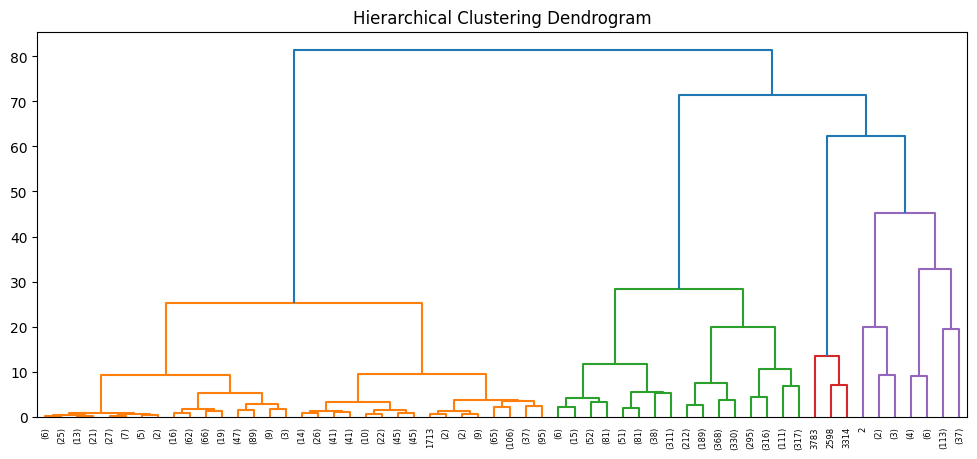

In [ ]:
# Perform Hierarchical Clustering
linkage_matrix = linkage(rfm_scaled, method='ward')
rfm["Cluster_Hierarchical"] = fcluster(linkage_matrix, optimal_clusters, criterion='maxclust')

# Dendrogram
plt.figure(figsize=(12, 5))
dendrogram(linkage_matrix, truncate_mode="level", p=5)
plt.title("Hierarchical Clustering Dendrogram")
plt.show()

In [ ]:
# Apply DBSCAN
dbscan = DBSCAN(eps=1.2, min_samples=5)
rfm["Cluster_DBSCAN"] = dbscan.fit_predict(rfm_scaled)

# Show unique cluster labels (-1 means noise points)
rfm["Cluster_DBSCAN"].value_counts()

,count
Cluster_DBSCAN,
0,3891
-1,29


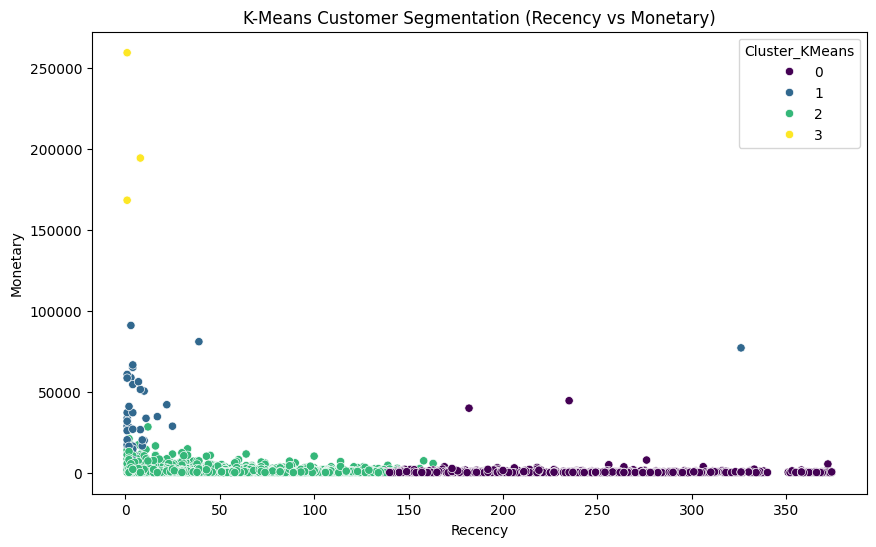

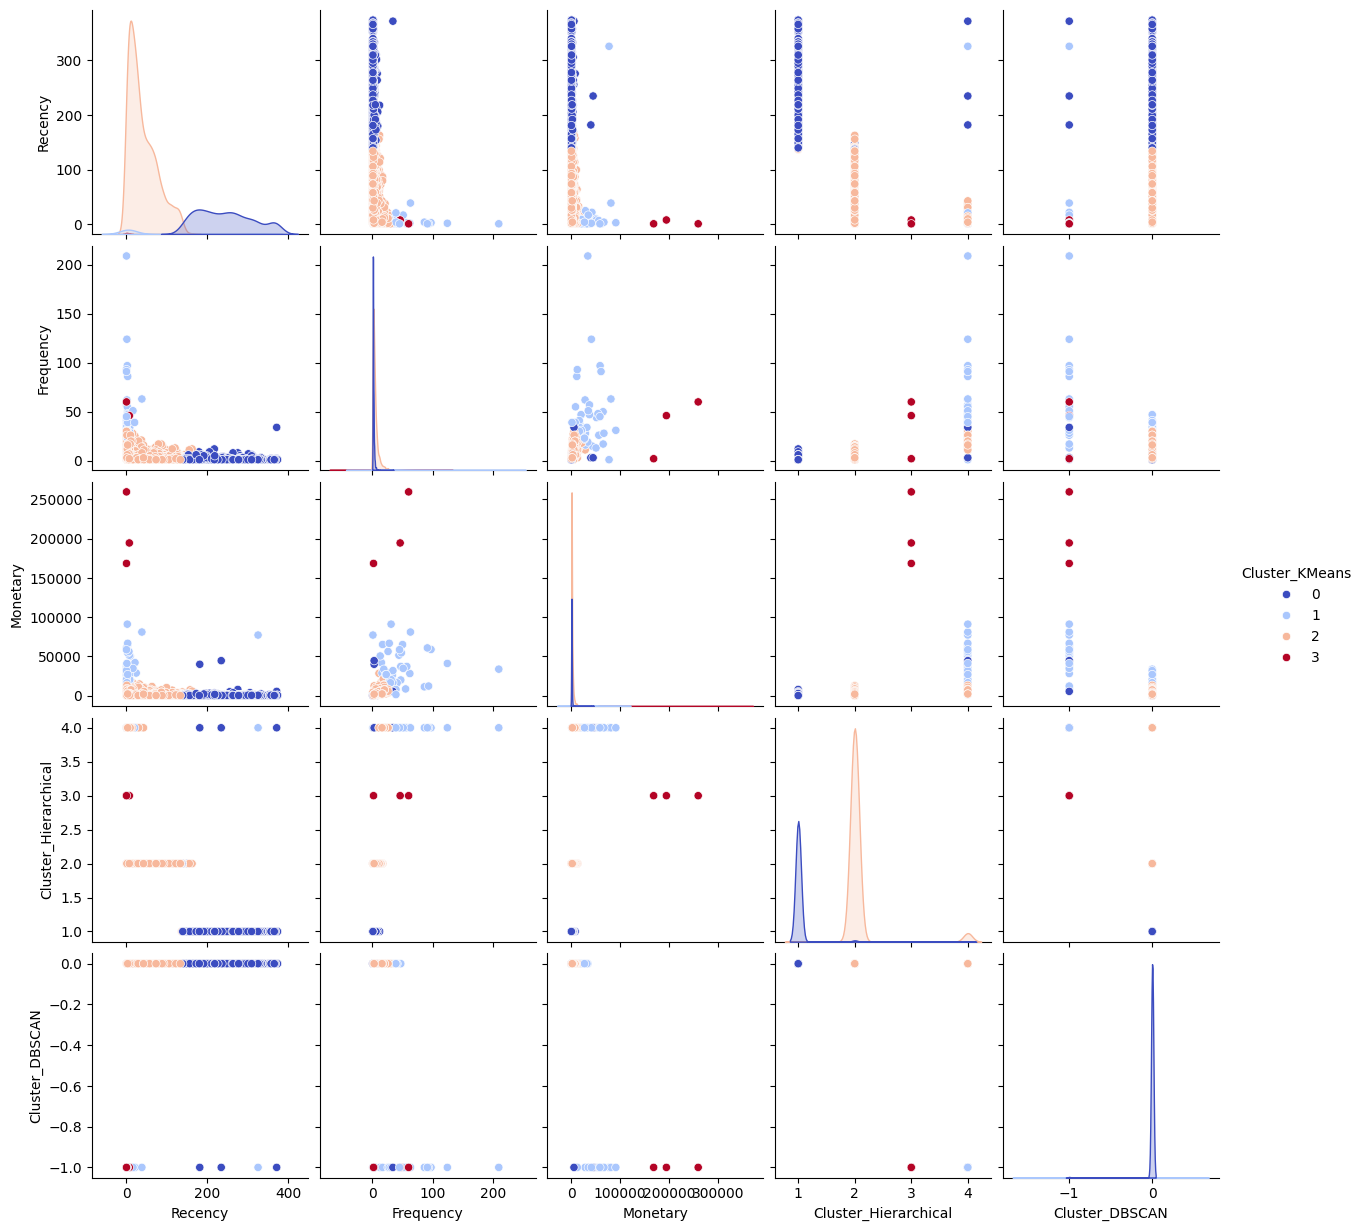

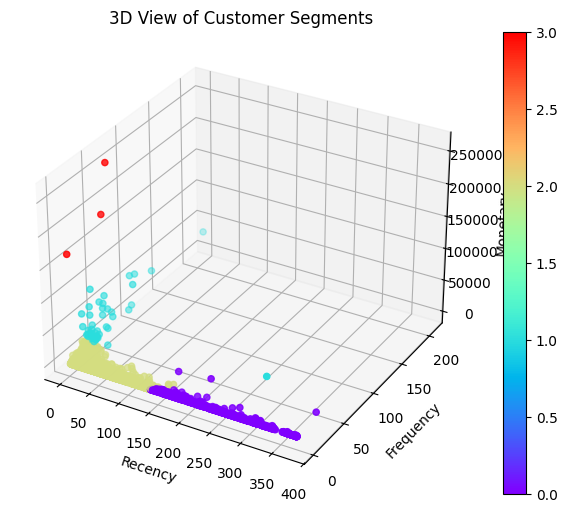

In [ ]:
# 2D Scatter Plot (Recency vs Monetary)
plt.figure(figsize=(10,6))
sns.scatterplot(data=rfm, x="Recency", y="Monetary", hue="Cluster_KMeans", palette="viridis")
plt.title("K-Means Customer Segmentation (Recency vs Monetary)")
plt.show()

# Pairplot for RFM Clusters
sns.pairplot(rfm, hue="Cluster_KMeans", palette="coolwarm")
plt.show()

# 3D Scatter Plot (Recency, Frequency, Monetary)
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d")
scatter = ax.scatter(rfm["Recency"], rfm["Frequency"], rfm["Monetary"], c=rfm["Cluster_KMeans"], cmap="rainbow")
ax.set_xlabel("Recency")
ax.set_ylabel("Frequency")
ax.set_zlabel("Monetary")
ax.set_title("3D View of Customer Segments")
plt.colorbar(scatter)
plt.show()

In [ ]:
# Define business recommendations for each segment (updated order)
recommendations = {
    3: "🟢 Best Customers - VIP programs & cross-selling",
    1: "🔵 Loyal Customers - Retention strategies",
    2: "🟠 Almost Lost - Reactivation offers",
    0: "🔴 Lost Customers - Win-back campaigns"
}

# Display sample customers per cluster
for cluster, rec in recommendations.items():
    print(f"\n{rec}")
    print("=" * 50)

    # Filter customers in the current cluster
    cluster_customers = rfm[rfm["Cluster_KMeans"] == cluster][['Recency', 'Monetary']]

    # Check if the cluster has customers before displaying
    if not cluster_customers.empty:
        print(cluster_customers.sample(n=min(3, len(cluster_customers)), random_state=42))  # Show random 3 customers
    else:
        print("No customers in this cluster.")

    print("=" * 50)


🟢 Best Customers - VIP programs & cross-selling
            Recency   Monetary
CustomerID                    
16446.0           1  168472.50
17450.0           8  194550.79
18102.0           1  259657.30

🔵 Loyal Customers - Retention strategies
            Recency  Monetary
CustomerID                   
14527.0           3   8508.82
17381.0           9  20275.61
17811.0           4   7837.73

🟠 Almost Lost - Reactivation offers
            Recency  Monetary
CustomerID                   
13995.0          15   1393.69
16399.0          19    408.57
15429.0          27    397.35

🔴 Lost Customers - Win-back campaigns
            Recency  Monetary
CustomerID                   
14059.0         267    183.60
14697.0         218    188.61
15609.0         184    298.48
